# Analysis of dip-response correlation

In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [94]:
# External packages
import os
import jupyter_slack
import datetime
from scipy.stats import pearsonr

# Internal modules
from usnm2p.logger import logger
from usnm2p.constants import *
from usnm2p.utils import *
from usnm2p.fileops import *
from usnm2p.postpro import *
from usnm2p.plotters import *
from usnm2p.batchutils import *
from usnm2p.indexers import FrameIndexer

# Root directory for output figures
figsdir = get_data_root(kind=DataRoot.FIG)  
logger.info(f'output figures directory: "{figsdir}"')

# Figures dictionary
figs = {}

 2025/07/16 14:20:10: output figures directory: "/Users/tlemaire/Documents/data/usnm/figs"


### Input datasets and main processing parameters

In [95]:
analysis_type = 'main'  # Analysis type
mouseline = 'pv'  # mouse line
layer = None  # cortical layer
slack_notify = False
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
gcamp_key = get_gcamp_key(mouseline)  # GCaMP channel key
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection

### Derived parameters

In [96]:
group_key, group_refval = {  # Grouping variable and reference value for the analysis
    'main': (Label.ISPTA, 0.),
    'offset': (Label.OFFSET, 2.0),
}[analysis_type]
refcolor = Palette.LINE[mouseline] # Reference color for the plot

# If global correction is dictionary, extract line-specific method
if isinstance(global_correction, dict):
    global_correction = global_correction[mouseline]

# Get batch-related settings
dataset_group_id, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_id = get_baseline_id(baseline_quantile, baseline_wquantile, baseline_wsmoothing)
 
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2025/07/16 14:20:10: assembling batch analysis settings...
 2025/07/16 14:20:10: pv main analysis notebook started on 2025-07-16 at 14:20:10


### Load dFF dip data

In [97]:
# Get data directory
dataroot = get_data_root(kind=DataRoot.PULSEDIP)
datadir = os.path.join(dataroot, analysis_type, mouseline)
logger.info(f'input data directory: {datadir}')

# List data files
datafiles = sorted([f for f in os.listdir(datadir) if f.endswith('.h5')])

stim_evoked_dFF, info_table = {}, {}

# For each input file
for fname in datafiles:
    # Parse dataset ID from file name
    dataset_ID = os.path.splitext(fname)[0]
    
    # Load pulse-dip data and info table
    sedFF, table = load_pulse_evoked_dip(os.path.join(datadir, fname))    

    # # If no baseline data, skip this dataset
    # if group_key == Label.ISPTA and not any(table[Label.P] == 0.):
    #     logger.warning(f'no data for P = 0 in {dataset_ID} -> skipping')
    #     continue
    
    # Restrict data to non-duplicated runs
    codefunc = get_param_code if group_key == Label.ISPTA else get_offset_code
    iruns = codefunc(table).drop_duplicates(keep='first').index.values
    table = table.loc[iruns]
    mux_slice = get_mux_slice(sedFF.index)
    mux_slice[0] = iruns
    sedFF = sedFF.loc[tuple(mux_slice)]

    # Add to dictionary
    stim_evoked_dFF[dataset_ID] = sedFF
    info_table[dataset_ID] = table

# Assemble data dictionaries into run-indexed pandas structures
logger.info(f'assembling and sorting data structures...')
stim_evoked_dFF = pd.concat(stim_evoked_dFF, axis=0, names=[Label.DATASET]).sort_index()
info_table = pd.concat(info_table, axis=0, names=[Label.DATASET]).sort_index()

# Extract constant parameters from info table
PRF = get_singleton(info_table, Label.PRF)
dur = get_singleton(info_table, Label.DUR)
fps = get_singleton(info_table, Label.FPS)
lpf = get_singleton(info_table, Label.LPF)
nframes_per_trial = get_singleton(info_table, Label.NPERTRIAL)
npulses = int(dur * PRF)

# Add relevant columns to info table
if group_key == Label.ISPTA:
    # For main analysis, add ISPTA and ISPPA columns
    info_table = add_intensity_to_table(info_table, precision=2)

    # Determine keys to add to trialagg_dFF
    exp_keys = [Label.P, Label.DC, Label.ISPPA, group_key]

elif group_key == Label.OFFSET:
    # For offset analysis, add transducer XY coordinates and offsets
    logger.info('parsing transducer XY offset coordinates...')
    offsets_2d = get_offset_complex(info_table)
    info_table['xoff (mm)'] = offsets_2d.apply(np.real)
    info_table['yoff (mm)'] = offsets_2d.apply(np.imag)
    xykeys = ['xoff (mm)', 'yoff (mm)']
    info_table[Label.OFFSET] = np.linalg.norm(info_table[xykeys], axis=1).round(2)

    # Determine keys to add to trialagg_dFF
    exp_keys = [Label.SUFFIX, *xykeys, group_key]

# # Add relevant columns to stim-evoked dFF data
stim_evoked_dFF = free_expand_and_add(info_table[exp_keys], stim_evoked_dFF.to_frame())

# # Remove data for DC = 1%, if present
# if Label.DC in stim_evoked_dFF.columns:
#     logger.info('removing data for DC = 1%')
#     toremove = info_table[info_table[Label.DC] == 1.0].index 
#     stim_evoked_dFF = stim_evoked_dFF.drop(toremove)
#     info_table = info_table.drop(toremove)

stim_evoked_dFF = harmonize_run_index(stim_evoked_dFF).sort_index()

stim_evoked_dFF

 2025/07/16 14:20:11: input data directory: /Users/tlemaire/Documents/data/usnm/pulsedip/main/pv
 2025/07/16 14:20:11: loading pulse-evoked dFF dip stats from 20190606_mouse2_region1.h5
 2025/07/16 14:20:11: loading experiment info table...
 2025/07/16 14:20:11: loading pulse-evoked dFF dip stats from 20190606_mouse2_region2.h5
 2025/07/16 14:20:11: loading experiment info table...
 2025/07/16 14:20:11: loading pulse-evoked dFF dip stats from 20190629_mouse2_region1.h5
 2025/07/16 14:20:11: loading experiment info table...
 2025/07/16 14:20:11: loading pulse-evoked dFF dip stats from 20190630_mouse3_region1.h5
 2025/07/16 14:20:11: loading experiment info table...
 2025/07/16 14:20:11: loading pulse-evoked dFF dip stats from 20190702_mouse1_region1.h5
 2025/07/16 14:20:11: loading experiment info table...
 2025/07/16 14:20:11: loading pulse-evoked dFF dip stats from 20190702_mouse5_region1.h5
 2025/07/16 14:20:11: loading experiment info table...
 2025/07/16 14:20:11: loading pulse-evo

pulse-evoked ΔF/F0 dip  P (MPa)  \
dataset                 run trial pulse                                    
20190606_mouse2_region1 0   0     0                   -0.019298      0.0   
                                  1                   -0.017730      0.0   
                                  2                   -0.024841      0.0   
                                  3                   -0.020669      0.0   
                                  4                   -0.014363      0.0   
...                                                         ...      ...   
20190821_mouse7_region1 14  15    15                  -0.091830      0.8   
                                  16                  -0.083287      0.8   
                                  17                  -0.069738      0.8   
                                  18                  -0.078372      0.8   
                                  19                  -0.073110      0.8   

                                         DC (%)  I_SPPA (W/cm2)  \
dataset                 run trial pulse                           
20190606_mouse2_region1 0   0     0        50.0            0.00   
                                  1        50.0            0.00   
                                  2        50.0            0.00   
                                  3        50.0            0.00   
                                  4        50.0            0.00   
...                                         ...             ...   
20190821_mouse7_region1 14  15    15       80.0           19.78   
                                  16       80.0           19.78   
                                  17       80.0           19.78   
                                  18       80.0           19.78   
                                  19       80.0           19.78   

                                         I_SPTA (W/cm2)  
dataset                 run trial pulse                  
20190606_mouse2_region1 0   0     0                0.00  
                                  1                0.00  
                                  2                0.00  
                                  3                0.00  
                                  4                0.00  
...                                                 ...  
20190821_mouse7_region1 14  15    15              15.83  
                                  16              15.83  
                                  17              15.83  
                                  18              15.83  
                                  19              15.83  

[44800 rows x 5 columns]

### Load response data

In [98]:
# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop_first'

# Load datasets
logger.info(f'loading data from {input_dir}:')
resp_stats = load_processed_datasets(
    input_dir, layer=layer,
    keys=['stats'],
    exclude_patterns=None,
    on_duplicate_runs=on_duplicate_runs)['stats']
logger.info('response stats successfully loaded.')

# Restrict to datasets present in both structures 
resp_stats = resp_stats.loc[stim_evoked_dFF.index.unique(Label.DATASET)].sort_index()

resp_stats

 2025/07/16 14:20:12: loading data from /Users/tlemaire/Documents/data/usnm/processed/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_stim-1->stimeverytrial/main/pv:
 2025/07/16 14:20:12: gathering dataset IDs...
 2025/07/16 14:20:12: loading mouse-region data from 20190606_mouse2_region1.h5
 2025/07/16 14:20:12: loading mouse-region data from 20190606_mouse2_region2.h5
 2025/07/16 14:20:12: loading mouse-region data from 20190629_mouse2_region1.h5
 2025/07/16 14:20:12: loading mouse-region data from 20190630_mouse3_region1.h5
 2025/07/16 14:20:12: loading mouse-region data from 20190702_mouse1_region1.h5
 2025/07/16 14:20:12: loading mouse-region data from 20190702_mouse5_region1.h5
 2025/07/16 14:20:12: loading mouse-region data from 20190703_mouse4_region1.h5
 2025/07/16 14:20:12: loading mouse-region data from 20190821_mouse3_region1.h5
 2025/07/16 14:20:12: loading mouse-region data from 2

line  trial_length  PRF (Hz)  \
dataset                 ROI run trial                                
20190606_mouse2_region1 2   0   0       pv           100     100.0   
                                1       pv           100     100.0   
                                2       pv           100     100.0   
                                3       pv           100     100.0   
                                4       pv           100     100.0   
...                                    ...           ...       ...   
20190821_mouse7_region1 890 14  11      pv           100     100.0   
                                12      pv           100     100.0   
                                13      pv           100     100.0   
                                14      pv           100     100.0   
                                15      pv           100     100.0   

                                       duration (s)   fps  P (MPa)  DC (%)  \
dataset                 ROI run trial                                        
20190606_mouse2_region1 2   0   0               0.2  3.56      0.0    50.0   
                                1               0.2  3.56      0.0    50.0   
                                2               0.2  3.56      0.0    50.0   
                                3               0.2  3.56      0.0    50.0   
                                4               0.2  3.56      0.0    50.0   
...                                             ...   ...      ...     ...   
20190821_mouse7_region1 890 14  11              0.2  3.56      0.8    80.0   
                                12              0.2  3.56      0.8    80.0   
                                13              0.2  3.56      0.8    80.0   
                                14              0.2  3.56      0.8    80.0   
                                15              0.2  3.56      0.8    80.0   

                                       run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
dataset                 ROI run trial                                           
20190606_mouse2_region1 2   0   0           6        0.000000         0.00000   
                                1           6        0.000000         0.00000   
                                2           6        0.000000         0.00000   
                                3           6        0.000000         0.00000   
                                4           6        0.000000         0.00000   
...                                       ...             ...             ...   
20190821_mouse7_region1 890 14  11         14       19.784475        15.82758   
                                12         14       19.784475        15.82758   
                                13         14       19.784475        15.82758   
                                14         14       19.784475        15.82758   
                                15         14       19.784475        15.82758   

                                       ...  baseline pre-stim avg Z(ΔF/F0)  \
dataset                 ROI run trial  ...                                   
20190606_mouse2_region1 2   0   0      ...                        0.430286   
                                1      ...                        0.673894   
                                2      ...                        0.016459   
                                3      ...                       -1.040600   
                                4      ...                        0.190192   
...                                    ...                             ...   
20190821_mouse7_region1 890 14  11     ...                        2.075091   
                                12     ...                       -0.318101   
                                13     ...                       -0.815383   
                                14     ...                       -0.827898   
                                15     ...                        0.420232   

                                       base

### Harmonize dip and response data

In [99]:
# Aggregate resp stats across ROIS
logger.info('aggregating response stats across ROIs')
aggtypes = {
    'first': [Label.LINE, Label.NPERTRIAL, Label.PRF, Label.DUR, Label.FPS, Label.P, Label.DC, Label.RUNID, Label.ISPPA, Label.ISPTA, Label.DISCARDED],
    'mean': get_change_key(Label.ZSCORE, full_output=True)
}
aggfuncs = {}
for aggfunc, keys in aggtypes.items():
    aggfuncs.update({kk: aggfunc for kk in keys})
roiagg_resp_stats = resp_stats.groupby([Label.DATASET, Label.RUN, Label.TRIAL]).agg(aggfuncs)

# Aggregate dip stats across pulses
logger.info('aggregating dip stats across pulses')
aggfuncs = {k: 'mean' if Label.DFF in k else 'first' for k in stim_evoked_dFF.columns}
pulseavg_stim_evoked_dFF = stim_evoked_dFF.groupby([Label.DATASET, Label.RUN, Label.TRIAL]).agg(aggfuncs)

# Restrict to only common index entries
logger.info('restricting to only common index entries')
pulseavg_stim_evoked_dFF = pulseavg_stim_evoked_dFF.loc[roiagg_resp_stats.index]

# Make sure that structures are indexed the same way
for k in [Label.P, Label.DC]:
    assert all(pulseavg_stim_evoked_dFF[k] == roiagg_resp_stats[k]), 'incompatible indexes'

# Combining into single data structure
logger.info('combining data structures')
data = roiagg_resp_stats.copy()
k = f'pulse-evoked {Label.DFF} dip'
data[k] = pulseavg_stim_evoked_dFF[k].abs()
data[Label.ISPTA] = data[Label.ISPTA].round(2)
data

 2025/07/16 14:20:17: aggregating response stats across ROIs
 2025/07/16 14:20:18: aggregating dip stats across pulses
 2025/07/16 14:20:18: restricting to only common index entries
 2025/07/16 14:20:18: combining data structures


line  trial_length  PRF (Hz)  duration (s)  \
dataset                 run trial                                              
20190606_mouse2_region1 0   0       pv           100     100.0           0.2   
                            1       pv           100     100.0           0.2   
                            2       pv           100     100.0           0.2   
                            3       pv           100     100.0           0.2   
                            4       pv           100     100.0           0.2   
...                                ...           ...       ...           ...   
20190821_mouse7_region1 14  11      pv           100     100.0           0.2   
                            12      pv           100     100.0           0.2   
                            13      pv           100     100.0           0.2   
                            14      pv           100     100.0           0.2   
                            15      pv           100     100.0           0.2   

                                    fps  P (MPa)  DC (%)  run ID  \
dataset                 run trial                                  
20190606_mouse2_region1 0   0      3.56      0.0    50.0       6   
                            1      3.56      0.0    50.0       6   
                            2      3.56      0.0    50.0       6   
                            3      3.56      0.0    50.0       6   
                            4      3.56      0.0    50.0       6   
...                                 ...      ...     ...     ...   
20190821_mouse7_region1 14  11     3.56      0.8    80.0      14   
                            12     3.56      0.8    80.0      14   
                            13     3.56      0.8    80.0      14   
                            14     3.56      0.8    80.0      14   
                            15     3.56      0.8    80.0      14   

                                   I_SPPA (W/cm2)  I_SPTA (W/cm2)  discarded  \
dataset                 run trial                                              
20190606_mouse2_region1 0   0            0.000000            0.00       True   
                            1            0.000000            0.00      False   
                            2            0.000000            0.00      False   
                            3            0.000000            0.00      False   
                            4            0.000000            0.00      False   
...                                           ...             ...        ...   
20190821_mouse7_region1 14  11          19.784475           15.83      False   
                            12          19.784475           15.83      False   
                            13          19.784475           15.83      False   
                            14          19.784475           15.83      False   
                            15          19.784475           15.83      False   

                                   pre-stim avg Z(ΔF/F0)  \
dataset                 run trial                          
20190606_mouse2_region1 0   0                  -0.087045   
                            1                   0.297277   
                            2                  -0.042382   
                            3                   0.008281   
                            4                  -0.058465   
...                                                  ...   
20190821_mouse7_region1 14  11                 -0.080274   
                            12                 -0.106910   
                            13                  0.057029   
                            14                  1.079123   
                            15                  0.697775   

                                   post-stim avg Z(ΔF/F0)  \
dataset                 run trial                           
20190606_mouse2_region1 0   0                    0.005031   
                            1                    0.317664   
                            2             

### Inspect correlation between dip and response

Text(0.5, 1.02, 'pv - (dip - response) relationship')

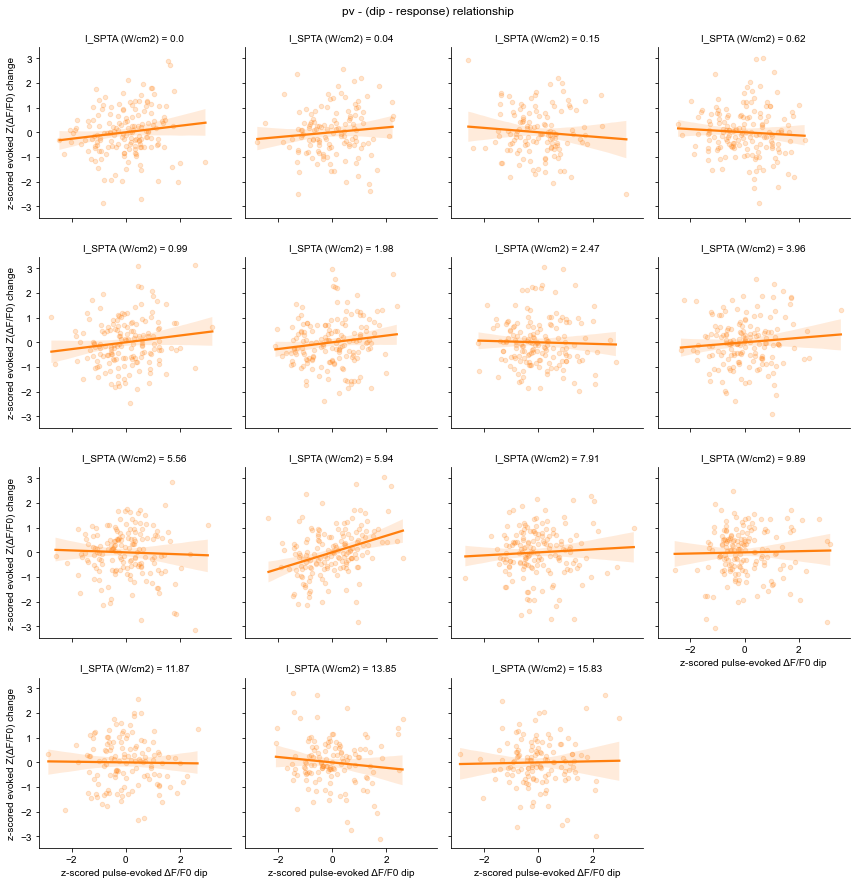

In [100]:
# Determine variables of interest
xykeys = {
    'x': f'pulse-evoked {Label.DFF} dip',
    'y': get_change_key(Label.ZSCORE)
}

# Z-score each variable along trial sequence for each dataset, run, combination
for k, v in xykeys.items():
    data[f'z-scored {v}'] = data[v].groupby([Label.DATASET, Label.RUN]).transform(lambda x: (x - x.mean()) / x.std())
zscored_xykeys = {k: f'z-scored {v}' for k, v in xykeys.items()}

# Plot
g = sns.lmplot(
    data=data,
    **zscored_xykeys,
    scatter_kws=dict(alpha=0.2, s=20, color=refcolor),
    line_kws=dict(color=refcolor),
    col=Label.ISPTA,
    col_wrap=4,
    height=3,
)
fig = g.figure
fig.suptitle(f'{mouseline} - (dip - response) relationship', y=1.02)